# In this project, I am using a movie dataset sourced from Kaggle. I will be using Linear regression to understand how various features influence movie ratings. The primary goal is to investigate the relationships between factors such as budget, genre, duration, year, and their impact on a movie's overall rating.

# **Initiate and Configure Spark**

In [ ]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=dd84ff37548cb6f96fad883b74fd62a3e7d63e4ad671624504df42c9c21176d6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
                    .appName("movieDataset") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "10g") \
                    .config("spark.driver.memory", "10g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **Task 1 - Data Loading and Preprocessing**
---

In [ ]:
# Load the data CSV file from google drive

df = spark.read.csv("/content/drive/MyDrive/ML&Bigdata/movies.csv", header=True, inferSchema=True)

In [ ]:
# View the dataset

df.show()

+----------+--------------------+-----------------+------+-------------+--------+--------------------+-----+------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        id|                name|             year|rating|  certificate|duration|               genre|votes|gross_income|       directors_id|      directors_name|            stars_id|          stars_name|         description|
+----------+--------------------+-----------------+------+-------------+--------+--------------------+-----+------------+-------------------+--------------------+--------------------+--------------------+--------------------+
| tt4710316|Best in Sex: 2015...|(2015 TV Special)|   4.0|        TV-MA|  94 min|         Adult, News|124.0|           0|          nm1624094|         Gary Miller|nm4766272,nm26705...|Farrah Laurel Abr...|The hottest adult...|
| tt1281857|    Naughty Novelist|     (2008 Video)|   3.8|Not Certified|  88 min|               

In [ ]:
# View number of non null values and columns in the data frame

print((df.count(), len(df.columns)))

(2593384, 14)


In [ ]:
# View the names of columns of the dataframe

df.columns

['id',
 'name',
 'year',
 'rating',
 'certificate',
 'duration',
 'genre',
 'votes',
 'gross_income',
 'directors_id',
 'directors_name',
 'stars_id',
 'stars_name',
 'description']

In [ ]:
# View data types in the dataset

df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- certificate: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- gross_income: string (nullable = true)
 |-- directors_id: string (nullable = true)
 |-- directors_name: string (nullable = true)
 |-- stars_id: string (nullable = true)
 |-- stars_name: string (nullable = true)
 |-- description: string (nullable = true)



In [ ]:
df.groupBy('genre').count().orderBy('count').show(10,False)

+-------------------------------+-----+
|genre                          |count|
+-------------------------------+-----+
|Western, Crime, Short          |1    |
|Crime, Short, Mystery          |1    |
|Fantasy, War, Horror           |1    |
|Horror, Action, Fantasy        |1    |
|Documentary, History, Animation|1    |
|Drama, Mystery, Horror         |1    |
|Drama, Crime, Musical          |1    |
|Horror, Short, Animation       |1    |
|Thriller, Drama, History       |1    |
|Crime, Documentary, Mystery    |1    |
+-------------------------------+-----+
only showing top 10 rows



Missing Values

In [ ]:
# As there are a total of 2593384 and roughly 2450 have missing values, this is a small percentage, less than 2% of missing data which should not largely impact the findings if deleted


from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

missing_values.show()

+---+----+----+------+-----------+--------+-----+-----+------------+------------+--------------+--------+----------+-----------+
| id|name|year|rating|certificate|duration|genre|votes|gross_income|directors_id|directors_name|stars_id|stars_name|description|
+---+----+----+------+-----------+--------+-----+-----+------------+------------+--------------+--------+----------+-----------+
|  0|2294|2398|  2430|       2449|    2449| 2449| 2449|        2449|        2449|          2450|    2450|      2450|       2450|
+---+----+----+------+-----------+--------+-----+-----+------------+------------+--------------+--------+----------+-----------+



In [ ]:
# Delete missing values within the dataset

df_cleaned = df.dropna()
df_cleaned.count()

2590934

In [ ]:
# Check that all rows with missing values have been removed

missing_values = df_cleaned.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])

missing_values.show()

+---+----+----+------+-----------+--------+-----+-----+------------+------------+--------------+--------+----------+-----------+
| id|name|year|rating|certificate|duration|genre|votes|gross_income|directors_id|directors_name|stars_id|stars_name|description|
+---+----+----+------+-----------+--------+-----+-----+------------+------------+--------------+--------+----------+-----------+
|  0|   0|   0|     0|          0|       0|    0|    0|           0|           0|             0|       0|         0|          0|
+---+----+----+------+-----------+--------+-----+-----+------------+------------+--------------+--------+----------+-----------+



In [ ]:
# Drop unecessary columns - the directors_name instead of directors id and stars_name instead of stars_id. They both represent the same thing.

df2=df_cleaned.drop('id', 'directors_name', 'stars_name')
df2.show(10)

+--------------------+-----------------+------+-------------+--------+--------------------+-----+------------+-------------------+--------------------+--------------------+
|                name|             year|rating|  certificate|duration|               genre|votes|gross_income|       directors_id|            stars_id|         description|
+--------------------+-----------------+------+-------------+--------+--------------------+-----+------------+-------------------+--------------------+--------------------+
|Best in Sex: 2015...|(2015 TV Special)|   4.0|        TV-MA|  94 min|         Adult, News|124.0|           0|          nm1624094|nm4766272,nm26705...|The hottest adult...|
|    Naughty Novelist|     (2008 Video)|   3.8|Not Certified|  88 min|               Adult|174.0|           0|          nm0045256|nm0128986,nm19691...|Darian is a succe...|
|2011 AVN Awards Show|(2011 TV Special)|   5.7|Not Certified|  83 min|         Adult, News| 39.0|           0|nm1624094,nm0754845|nm220

In [ ]:
# Convert Columns 'rating','votes' and 'gross_income' to numerical format

from pyspark.sql.functions import col
df2 = df2.withColumn("ranking", col("rating").cast("double"))
df2 = df2.withColumn("public_vote", col("votes").cast("double"))
df2 = df2.withColumn("income", col("gross_income").cast("double"))

In [ ]:
# View data types to check if the new columns with their new data types have been created

df2.printSchema()

root
 |-- name: string (nullable = true)
 |-- year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- certificate: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- gross_income: string (nullable = true)
 |-- directors_id: string (nullable = true)
 |-- stars_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ranking: double (nullable = true)
 |-- public_vote: double (nullable = true)
 |-- income: double (nullable = true)



In [ ]:
df3=df2.select('name','description','year','certificate','duration','genre','directors_id','stars_id','income','public_vote','ranking')
df3.show()

+--------------------+--------------------+-----------------+-------------+--------+--------------------+-------------------+--------------------+------+-----------+-------+
|                name|         description|             year|  certificate|duration|               genre|       directors_id|            stars_id|income|public_vote|ranking|
+--------------------+--------------------+-----------------+-------------+--------+--------------------+-------------------+--------------------+------+-----------+-------+
|Best in Sex: 2015...|The hottest adult...|(2015 TV Special)|        TV-MA|  94 min|         Adult, News|          nm1624094|nm4766272,nm26705...|   0.0|      124.0|    4.0|
|    Naughty Novelist|Darian is a succe...|     (2008 Video)|Not Certified|  88 min|               Adult|          nm0045256|nm0128986,nm19691...|   0.0|      174.0|    3.8|
|2011 AVN Awards Show|          Add a Plot|(2011 TV Special)|Not Certified|  83 min|         Adult, News|nm1624094,nm0754845|nm220

String Indexer

In [ ]:
# Convert all categorical data columns into numerical format

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'certificate', outputCol = 'certified')
indexer2 = StringIndexer(inputCol = 'genre', outputCol = 'movie_genre')
indexer3 = StringIndexer(inputCol = 'duration', outputCol = 'movie_length')
indexer4 = StringIndexer(inputCol = 'directors_id', outputCol = 'directors')
indexer5 = StringIndexer(inputCol = 'stars_id', outputCol = 'stars')
indexer6 = StringIndexer(inputCol = 'year', outputCol = 'date')
df3 = indexer.fit(df3).transform(df3)
df3 = indexer2.fit(df3).transform(df3)
df3 = indexer3.fit(df3).transform(df3)
df3 = indexer4.fit(df3).transform(df3)
df3 = indexer5.fit(df3).transform(df3)
df3 = indexer6.fit(df3).transform(df3)
df3.show(10)

+--------------------+--------------------+-----------------+-------------+--------+--------------------+-------------------+--------------------+------+-----------+-------+---------+-----------+------------+---------+---------+-----+
|                name|         description|             year|  certificate|duration|               genre|       directors_id|            stars_id|income|public_vote|ranking|certified|movie_genre|movie_length|directors|    stars| date|
+--------------------+--------------------+-----------------+-------------+--------+--------------------+-------------------+--------------------+------+-----------+-------+---------+-----------+------------+---------+---------+-----+
|Best in Sex: 2015...|The hottest adult...|(2015 TV Special)|        TV-MA|  94 min|         Adult, News|          nm1624094|nm4766272,nm26705...|   0.0|      124.0|    4.0|      4.0|     1870.0|        64.0|  65067.0| 865645.0|573.0|
|    Naughty Novelist|Darian is a succe...|     (2008 Video)

In [ ]:
# Select all string indexed columns into a new dataframe

df4=df3.select('name','description','date','certified','movie_length','movie_genre','directors','stars','income','public_vote','ranking')
df4.show()

+--------------------+--------------------+-----+---------+------------+-----------+---------+---------+------+-----------+-------+
|                name|         description| date|certified|movie_length|movie_genre|directors|    stars|income|public_vote|ranking|
+--------------------+--------------------+-----+---------+------------+-----------+---------+---------+------+-----------+-------+
|Best in Sex: 2015...|The hottest adult...|573.0|      4.0|        64.0|     1870.0|  65067.0| 865645.0|   0.0|      124.0|    4.0|
|    Naughty Novelist|Darian is a succe...|153.0|      0.0|        50.0|     1420.0|   9342.0| 228355.0|   0.0|      174.0|    3.8|
|2011 AVN Awards Show|          Add a Plot|580.0|      0.0|        67.0|     1870.0| 319959.0| 704486.0|   0.0|       39.0|    5.7|
|Best in Sex: 2017...|Considered the in...|563.0|      4.0|        55.0|     1870.0|  65067.0| 889253.0|   0.0|      225.0|    4.9|
|     AVN Awards 2014|Erotic filmmaking...|579.0|      9.0|        68.0|    

In [ ]:
# Starting with tokenization of the two text columns to split the text into individual words/tokens

from pyspark.ml.feature import Tokenizer
tokenization=Tokenizer(inputCol='name',outputCol='title')
tokenization2=Tokenizer(inputCol='description',outputCol='summary')
tokenized_df2 = tokenization.transform(df4)
tokenized_df2 = tokenization2.transform(tokenized_df2)
tokenized_df2.show(4,False)

+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+---------+------------+-----------+---------+--------+------+-----------+-------+-----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|name                        |description                                                                                                                                                                                                                              |date |certified|movie_length|movie_genre|directors|stars   |income|publ

In [ ]:
# This has now removed stop words such as the, and, in from both 'summary' and 'title' columns and outputted into new columns 'refined_summary' and 'refined_title'

from pyspark.ml.feature import StopWordsRemover

stopword_removal=StopWordsRemover(inputCol='title',outputCol='refined_title')
stopword_removal2=StopWordsRemover(inputCol='summary',outputCol='refined_summary')
refined_df2=stopword_removal.transform(tokenized_df2)
refined_df2=stopword_removal2.transform(refined_df2)

refined_df2.show(10,False)

+----------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+---------+------------+-----------+---------+---------+------+-----------+-------+--------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|name                     

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Tidy up the text by using lemmatizer to reduce words to their base form

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer


def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas


lemmatize_udf = udf(lemmatize_text, ArrayType(StringType()))

# Apply lemmatization using the User Defined Function
refined_df2 = refined_df2.withColumn("lemmatized_title", lemmatize_udf("refined_title"))
refined_df2 = refined_df2.withColumn("lemmatized_summary", lemmatize_udf("refined_summary"))

# View the resulting Dataframe
refined_df2.show(truncate=False)



+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+---------+------------+-----------+---------+---------+------+-----------+-------+--------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Use Hashing TF-DF to find out the importance of each word which is then given a number

from pyspark.ml.feature import HashingTF,IDF
hashing_vec2=HashingTF(inputCol='lemmatized_title',outputCol='title_features')
hashing_vec3=HashingTF(inputCol='lemmatized_summary',outputCol='summary_features')
hashing_df2=hashing_vec2.transform(refined_df2)
hashing_df2=hashing_vec3.transform(hashing_df2)
hashing_df2.select(['lemmatized_title','title_features','lemmatized_summary','summary_features']).show(4,False)

+------------------------------+------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|lemmatized_title              |title_features                                                    |lemmatized_summary                                                                                                                                                                                                                      |summary_features                       

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

input_cols=['title_features', 'summary_features','date','public_vote','movie_genre','directors','stars','movie_length','certified','income',]

# Assemble all features together using vector assembler so this can be easily fed into the maching learning model

vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(hashing_df2)
final_data.show()

+--------------------+--------------------+-----+---------+------------+-----------+---------+---------+------+-----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|         description| date|certified|movie_length|movie_genre|directors|    stars|income|public_vote|ranking|               title|             summary|       refined_title|     refined_summary|    lemmatized_title|  lemmatized_summary|      title_features|    summary_features|            features|
+--------------------+--------------------+-----+---------+------------+-----------+---------+---------+------+-----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Best in Sex: 2015...|The hottest adu

In [ ]:
# Select final data frame being the features and label column 'ranking'

final_data3=final_data.select('features','ranking')
final_data3.show()

+--------------------+-------+
|            features|ranking|
+--------------------+-------+
|(524296,[75368,16...|    4.0|
|(524296,[101219,2...|    3.8|
|(524296,[201939,2...|    5.7|
|(524296,[38058,16...|    4.9|
|(524296,[201939,2...|    6.7|
|(524296,[3837,927...|    6.0|
|(524296,[25159,50...|    6.8|
|(524296,[182804,2...|    7.1|
|(524296,[175966,2...|    7.3|
|(524296,[150106,1...|    2.9|
|(524296,[240176,2...|    5.9|
|(524296,[55748,13...|    4.1|
|(524296,[47672,20...|    7.1|
|(524296,[45399,46...|    5.1|
|(524296,[38640,51...|    4.1|
|(524296,[29528,12...|    6.1|
|(524296,[55339,26...|    7.3|
|(524296,[10564,15...|    7.0|
|(524296,[163059,1...|    2.2|
|(524296,[133567,2...|   11.0|
+--------------------+-------+
only showing top 20 rows



In [ ]:
# Adjust the numerical data so that they are centered around zero and have a standard deviation of 1 to limit bias

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')


scaler_model = scaler.fit(final_data3)
final_data3 = scaler_model.transform(final_data3)

final_data3 = final_data3.select('scaledFeatures', 'ranking')
final_data3.show(5, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Training data, test data split

In [ ]:
# Split data to prepare for training

train_data, test_data = final_data3.randomSplit([0.7, 0.3], seed = 42)
train_data.show(5, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|scaledFeatures                                                                                                                                                             

---
# **Task 2 - Model Selection and Implementation**
---

In [ ]:
# Train linear regression model

lr = LinearRegression(labelCol = 'ranking', featuresCol = 'scaledFeatures', predictionCol = 'prediction')

lr_model = lr.fit(train_data)

In [ ]:
lr_predictions = lr_model.transform(test_data)

In [ ]:
# Show predictions for the model

lr_predictions.select('prediction', 'ranking').show(10, truncate = False)

+------------------+-------+
|prediction        |ranking|
+------------------+-------+
|11.123386790966936|11.0   |
|8.706421969078406 |11.0   |
|6.107441286505636 |11.0   |
|10.029339226136528|11.0   |
|10.310306286396612|11.0   |
|10.939601362430352|11.0   |
|10.983130040882596|11.0   |
|10.19482142036776 |6.8    |
|5.553183199999776 |11.0   |
|8.407927462602114 |11.0   |
+------------------+-------+
only showing top 10 rows



In [ ]:
# Apply the coefficients and intecepts

coefficients = lr_model.coefficients
intercept = lr_model.intercept

---
# **Task 3 - Model Parameter Tuning**
---

In [ ]:
# Train the Lasso model
lasso = LinearRegression(labelCol = 'ranking', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.15)
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

# Train the Ridge model
ridge = LinearRegression(labelCol = 'ranking', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

In [ ]:
# Print lasso model predictions

lasso_predictions.select('prediction', 'ranking').show(10, truncate = False)

+-----------------+-------+
|prediction       |ranking|
+-----------------+-------+
|8.855714875854476|11.0   |
|9.612252579623389|11.0   |
|9.236476592976429|11.0   |
|9.90838389473197 |11.0   |
|9.965433833110572|11.0   |
|9.79067599436856 |11.0   |
|9.236476592976429|11.0   |
|9.609165040773794|6.8    |
|9.625525733215467|11.0   |
|9.817460556107958|11.0   |
+-----------------+-------+
only showing top 10 rows



---
# **Task 4 - Model Evaluation and Accuracy Calculation**
---

In [ ]:
# Measure the average squared difference between predicted values and actual values

from pyspark.ml.evaluation import RegressionEvaluator

evaluator_mse = RegressionEvaluator(labelCol = 'ranking', predictionCol = 'prediction', metricName = 'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)


In [ ]:
# Measure the square root of the MSE

evaluator_rmse = RegressionEvaluator(labelCol = 'ranking', predictionCol = 'prediction', metricName = 'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)

# Measure how well the independant variables predict the actual data

evaluator_r2 = RegressionEvaluator(labelCol = 'ranking', predictionCol = 'prediction', metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(lr_predictions)
r2_score2 = evaluator_r2.evaluate(lasso_predictions)
r2_score3 = evaluator_r2.evaluate(ridge_predictions)

In [ ]:
# Print full evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_score2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_score3)

Regression - MSE:  3.162624008531466 , RMSE:  1.7783767903713392 , R^2:  0.037606192397890426
Lasso - MSE:  2.3875812451389478 , RMSE:  1.5451800041221566 , R^2:  0.2734534996034461
Ridge - MSE:  2.4118655262705526 , RMSE:  1.5530181989502096 , R^2:  0.26606373663444316


---
# **Task 5 - Results Visualization or Printing**
---

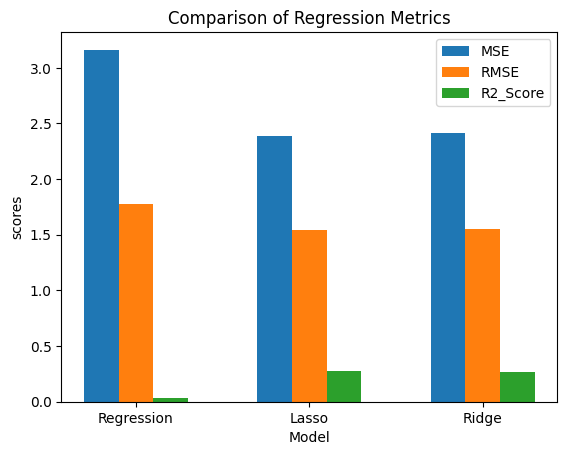

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_score = [r2_score1, r2_score2, r2_score3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# add titles
plt.xlabel('Model')
plt.ylabel('scores')
plt.title('Comparison of Regression Metrics')

# add legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()

**Regression model:**

- The regression model has a high MSE of 3.162624008531466 and RMSE of 1.7783767903713392 meaning the predicted values are roughly 1.7783 from the actual values.

- R-squared at 0.0376 suggests that only a small percentage, roughly 4% of the variability in movie ratings is explained by the features. This indicates that the linear regression model may not be capturing the complex relationships between the features and movie ratings well.

- The model may not be accurately capturing the relationships between the features (genre, title, movie length, votes, directors, stars) and movie ratings.


**Lasso model:**

- The Lasso model has a lower MSE 2.3875812451389478 and RMSE 1.5451800041221566 which shows that this models predictions are closer to the actual values - resulting in a better model than the basic regression model

**Ridge model:**

- The Ridge model also has lower MSE 2.4118655262705526 and RMSE  1.5530181989502096 - but evidently not lower than the lasso model. this shows this model performs better than the basic regression model but not better than the lasso model




A possible ethical concern i noticed was around representation. The underrepresentation of certain genres, stars and directors can lead to biases within results. This would improve by having a diverse dataset containing a variety of these underrepresented figures.